In [48]:
import glob
from matplotlib import image 
from matplotlib import pyplot as plt
from PIL import Image
import os
import cv2 as cv
import numpy as np
import scipy.io
import random
from sklearn.cluster import KMeans

# 1. Download the Dataset and Understand the Format

In [49]:
!wget -q {"http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"}
!tar -xzf /content/BSR_bsds500.tgz


'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open '/content/BSR_bsds500.tgz'


In [50]:
# Creating the output directory
!mkdir '/content/output'
!mkdir '/content/output/Ground-Truth'


The syntax of the command is incorrect.
The syntax of the command is incorrect.


In [51]:
#saving output
directory = "content"
    
# Parent Directory path
parent_dir = "."

# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Create 'output' directory to save all outputs inside
directory = "output"
    
# Parent Directory path
parent_dir = "./content"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Create 'Ground Truth' directory
directory = "Ground-Truth"
    
# Parent Directory path
parent_dir = "./content/output"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

In [52]:
#Get the images for training
training_images = sorted(glob.glob("BSR/BSDS500/data/images/train/**/*.jpg", recursive=True))

#Get the images for testing
testing_images = sorted(glob.glob("BSR/BSDS500/data/images/test/**/*.jpg", recursive=True))
testing_images = testing_images[0:50]

#Get the ground-truth for training
ground_truth_training = sorted(glob.glob("BSR/BSDS500/data/groundTruth/train/**/*.mat", recursive=True))

#Get the ground-truth for testing
ground_truth_testing = sorted(glob.glob("BSR/BSDS500/data/groundTruth/test/**/*.mat", recursive=True))
ground_truth_testing = ground_truth_testing[0:50]

In [53]:
# Loading images
testing_data = []
for path in testing_images:
    img = image.imread(path)
    testing_data.append(img)


In [54]:
testing_data[0].shape

(321, 481, 3)

# 2. Visualize the image and the ground truth segmentation


In [55]:
def ground_truth_images_func(index,dataset):
  ground_truth_image = scipy.io.loadmat(dataset[index])
  ground_truth_image = np.squeeze(ground_truth_image['groundTruth'])
  ground_truth_images = [] #making a list for the ground truth images 
  for i in range(5):
    current_ground_truth = ground_truth_image[i][0][0][0]
    ground_truth_images.append(current_ground_truth)
  
  return ground_truth_images


In [56]:
def read_image(index, dataset):
  path='./content/output/Ground-Truth'  #output is saved here
  file_name = str(dataset).lower() + ' ' + str(index) + ' visualization' #file name
  fig, axarr = plt.subplots(2,3, figsize = (8, 8))

  if dataset == "TRAIN":
    normal_dataset = training_images
    ground_truth_dataset = ground_truth_training
  if dataset == "TEST":
    normal_dataset = testing_images
    ground_truth_dataset = ground_truth_testing

  #creating an empty list of images
  images = []  
  normal_image = image.imread(normal_dataset[index])
  images.append(normal_image)
  ground_truth_images = ground_truth_images_func(index,  ground_truth_dataset) # Getting the ground truth of the image
  images = images + ground_truth_images  # to display all
  #looping through the images list to show the image
  for i in range(len(images)):
    row = i // 3
    col = i % 3
    if i == 0:
      axarr[row][col].imshow(images[0])
    axarr[i // 3][i % 3].imshow(images[i], interpolation='nearest')
  fig.suptitle(file_name, fontsize=16)
  plt.savefig(os.path.join(path, file_name), bbox_inches = 'tight')
  plt.show()


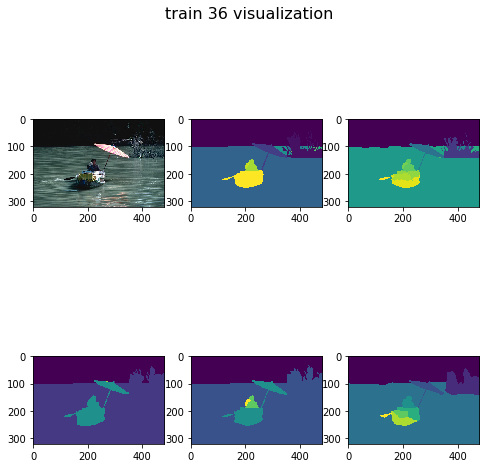

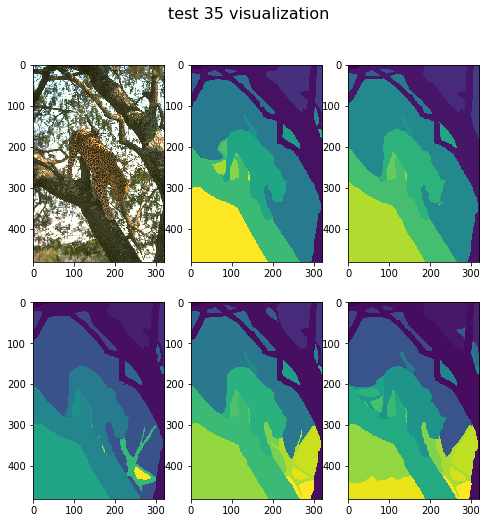

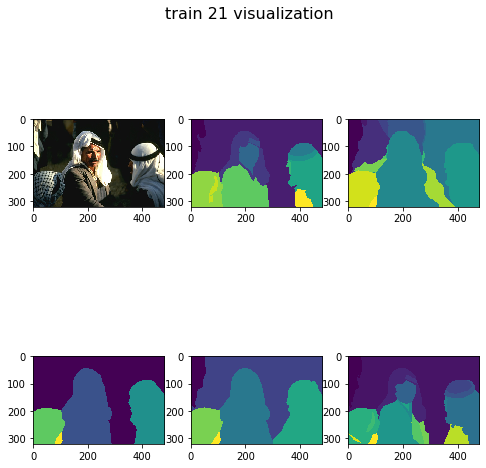

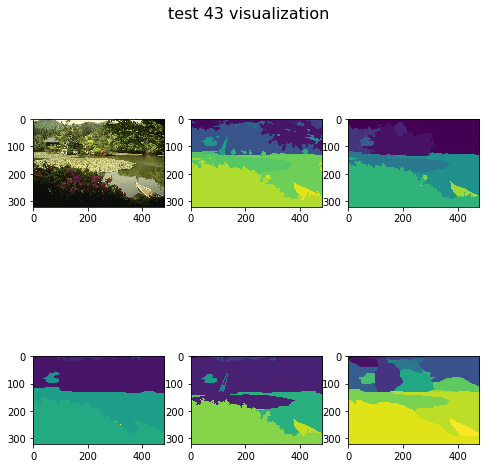

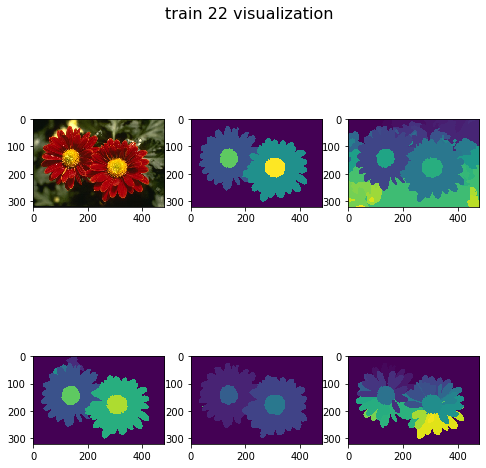

In [57]:

datasets = ["TRAIN", "TEST"]
random_images = random.sample(range(0, 50), 5) # Calling the above function to get 2 random images to visualize

# Visualize a sample from training dataset and a sample from test data set alternatively
for i in range(len(random_images)):
    read_image(random_images[i], datasets[i & 1])

In [58]:
'''# For the comparison part
f = []
for i in range(len(random_images)):
  f.append(ground_truth_images_func(random_images[i], datasets[i & 1]))'''

'# For the comparison part\nf = []\nfor i in range(len(random_images)):\n  f.append(ground_truth_images_func(random_images[i], datasets[i & 1]))'

In [59]:
# from google.colab import files
# !zip -qq -r /content/output.zip /content/output
# files.download("/content/output.zip")

# 3. Segmentation using K-means

In [60]:
K_range= [3,5,7,9,11]

In [61]:
def plot_img_seg(img, seg, k):
    figure_size = 15
    plt.figure(figsize=(figure_size,figure_size))
    plt.subplot(1,2,1),plt.imshow(img)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,2,2),plt.imshow(seg)
    plt.title('Segmented Image when K = %i' % k), plt.xticks([]), plt.yticks([])
    plt.show()

In [62]:
def kmean_f(img, k):
    feature = img.reshape((-1, 3))
    km = KMeans(n_clusters=k)
    km.fit(feature)
    seg = km.predict(feature)
    seg = seg.reshape((img[:, :, 0].shape))
    return seg

In [63]:
path='./content/output/Result'
ind_name = 0
pred_img = []
for test_img in testing_data:
    image_list = []
    fig, axarr = plt.subplots(2,3, figsize = (15, 15))
    file_name = 'img_' + str(ind_name)
    image_list.append(test_img)
    for k in K_range:
        image_list.append(kmean_f(test_img, k))
    pred_img.append(image_list[1:])
    for i in range(len(image_list)):
        row = i // 3
        col = i % 3
        if i == 0:
            axarr[row][col].imshow(image_list[0])
        axarr[i // 3][i % 3].imshow(image_list[i], interpolation='nearest')
    
    fig.suptitle(file_name, fontsize=16)
    plt.savefig(os.path.join(path, file_name), bbox_inches = 'tight')
    plt.close(fig)
    ind_name += 1 

# 4. Big Picture 

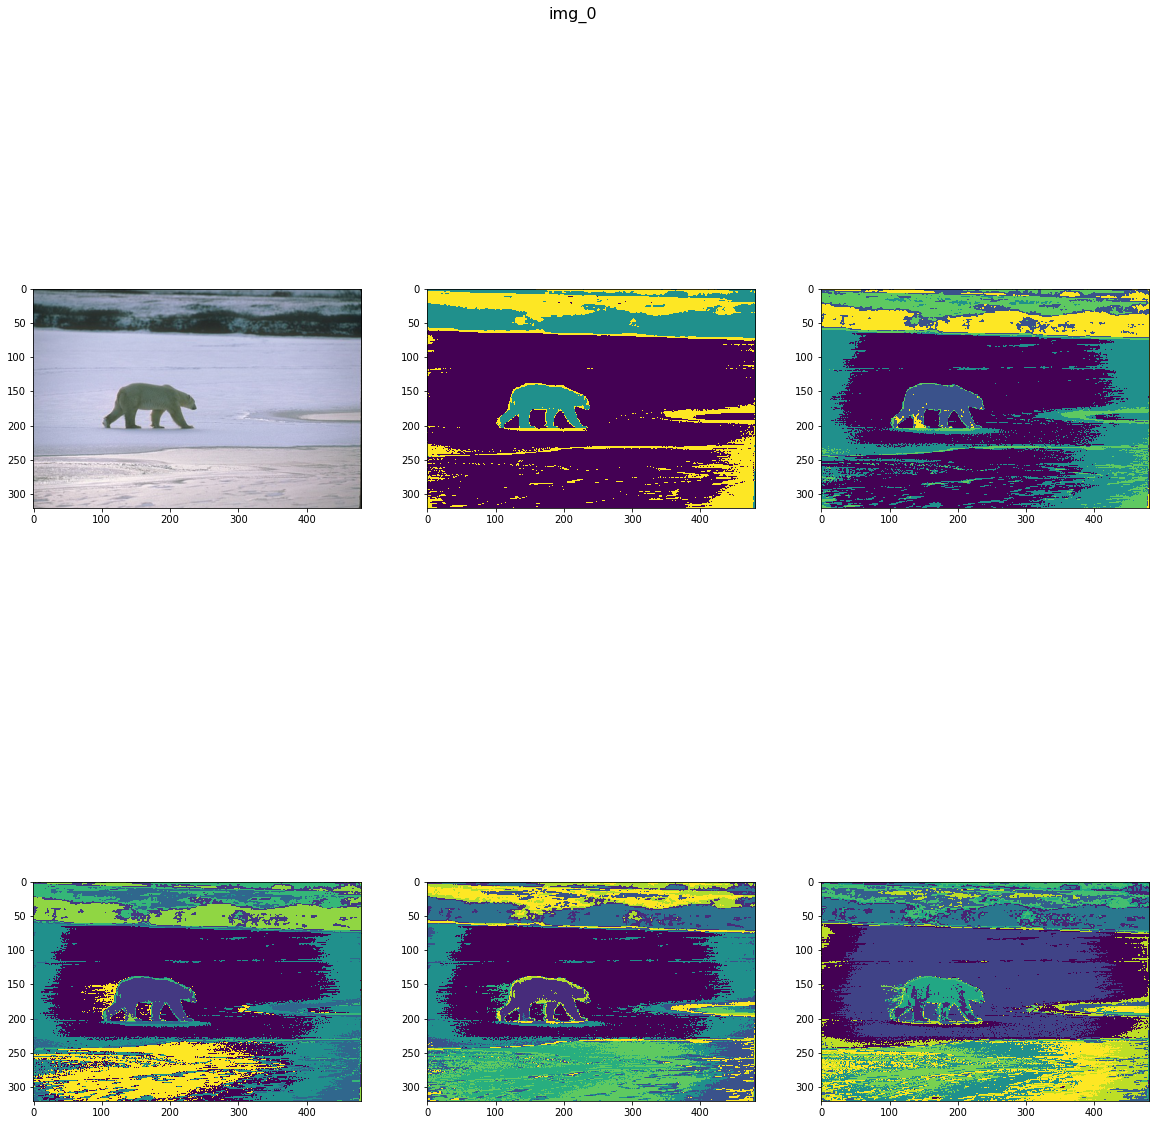

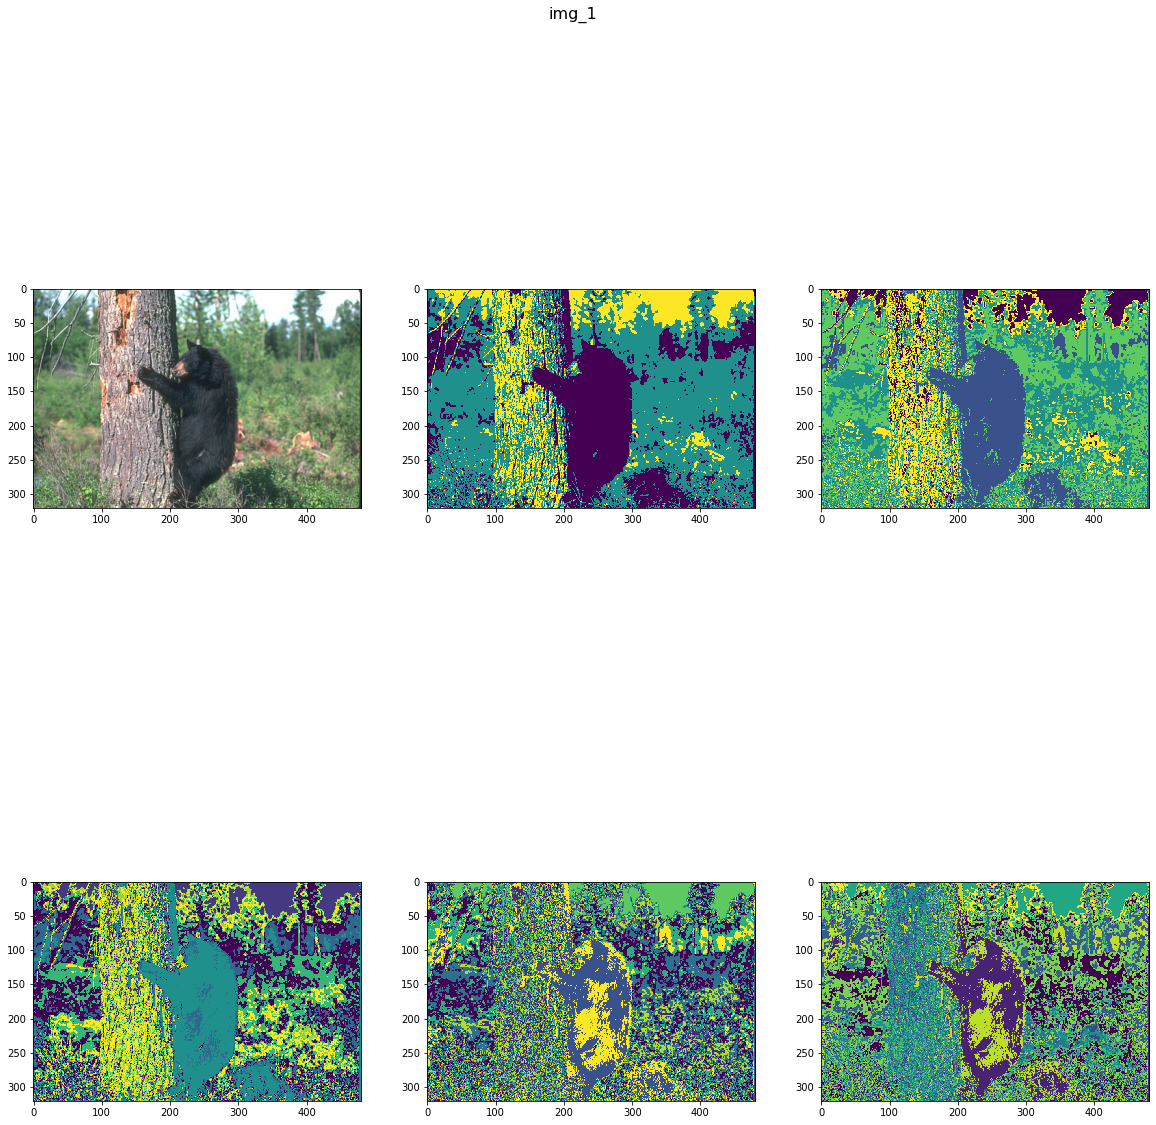

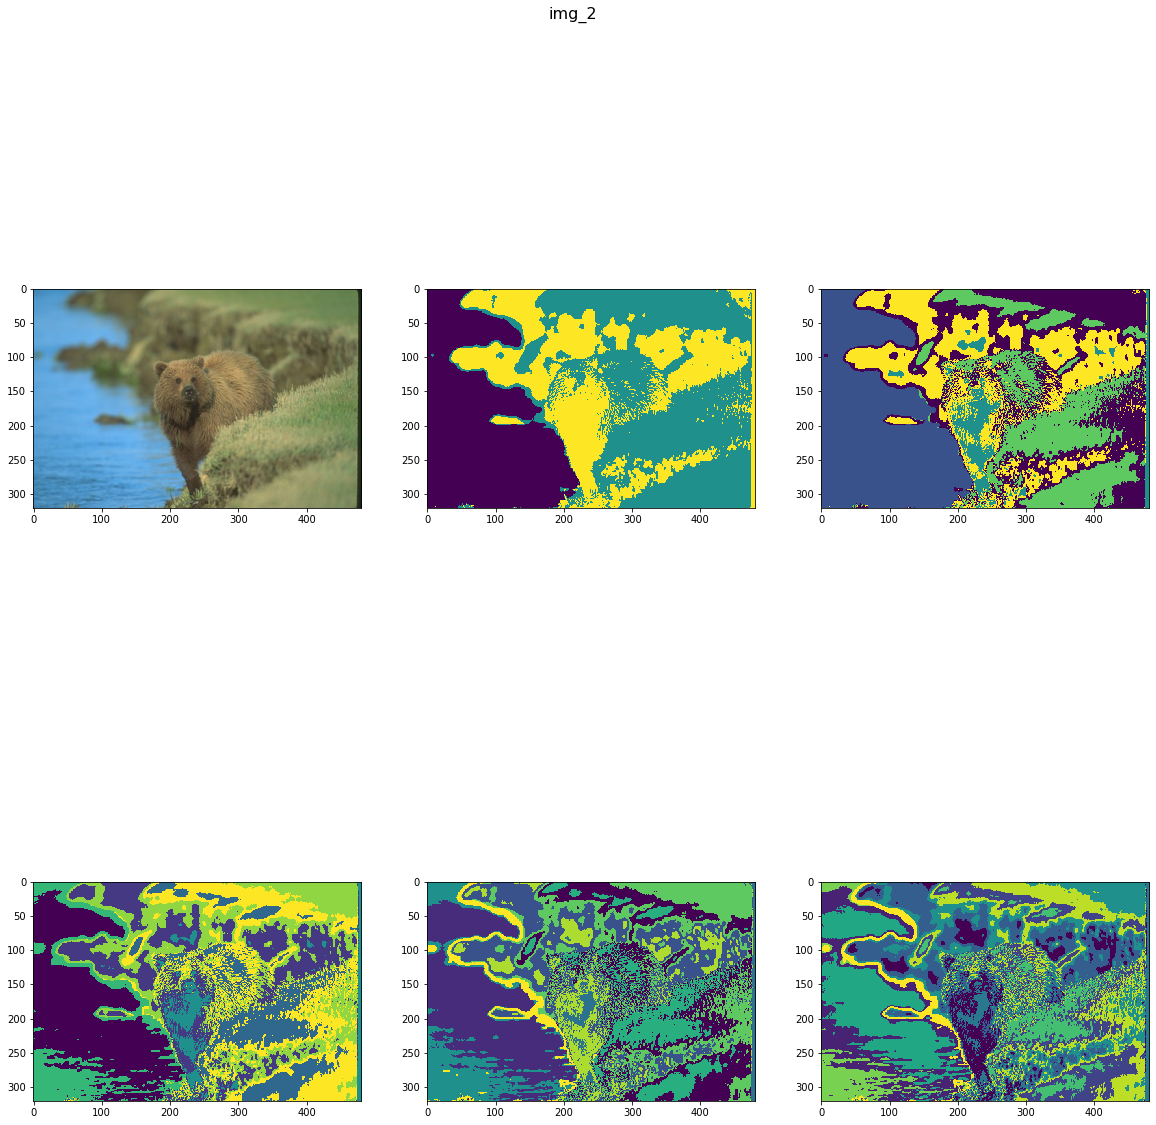

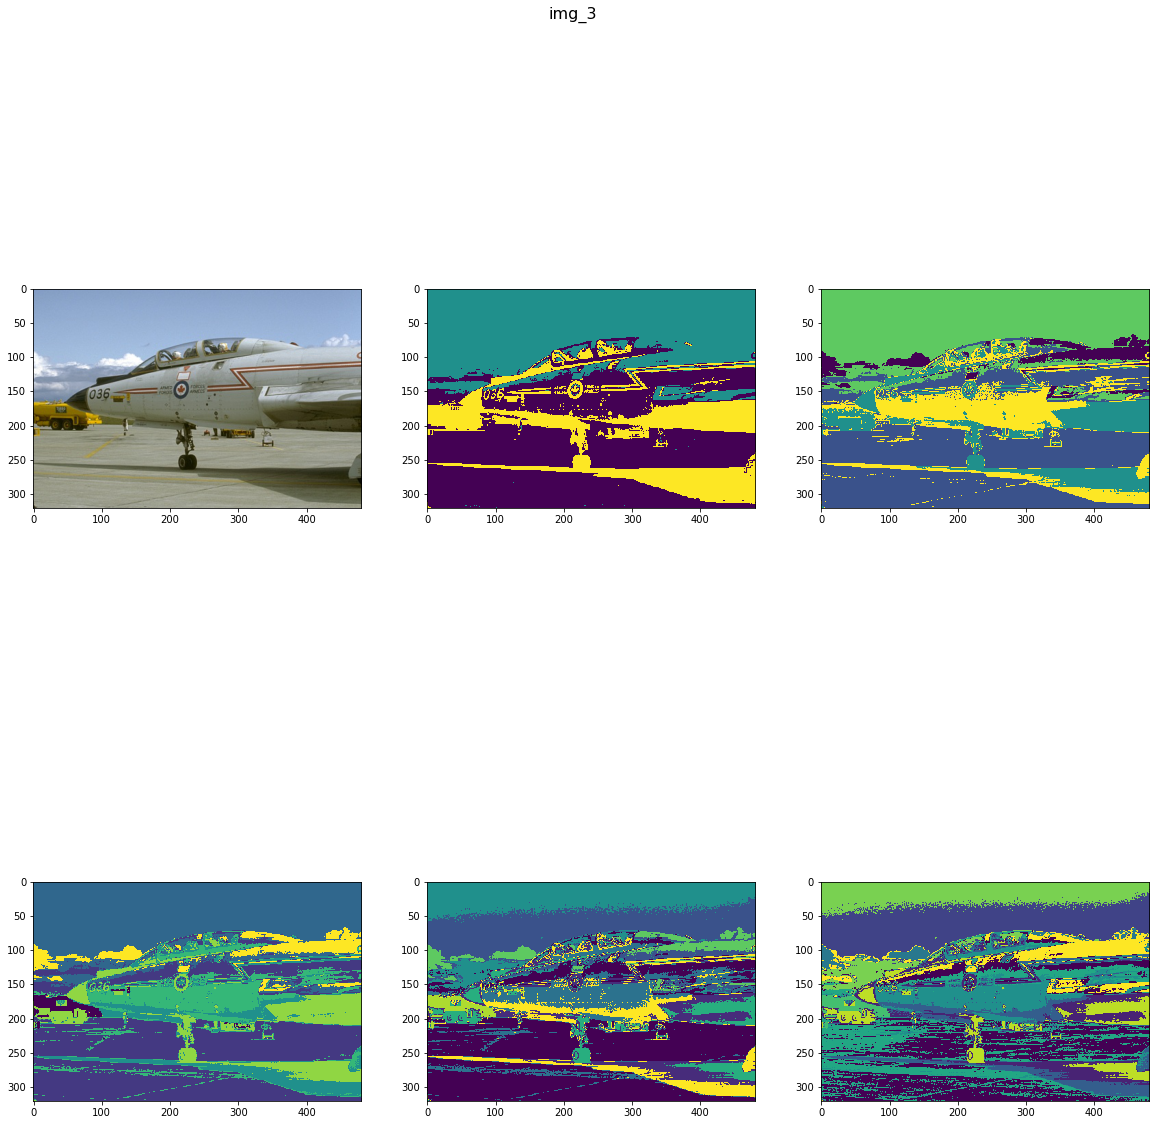

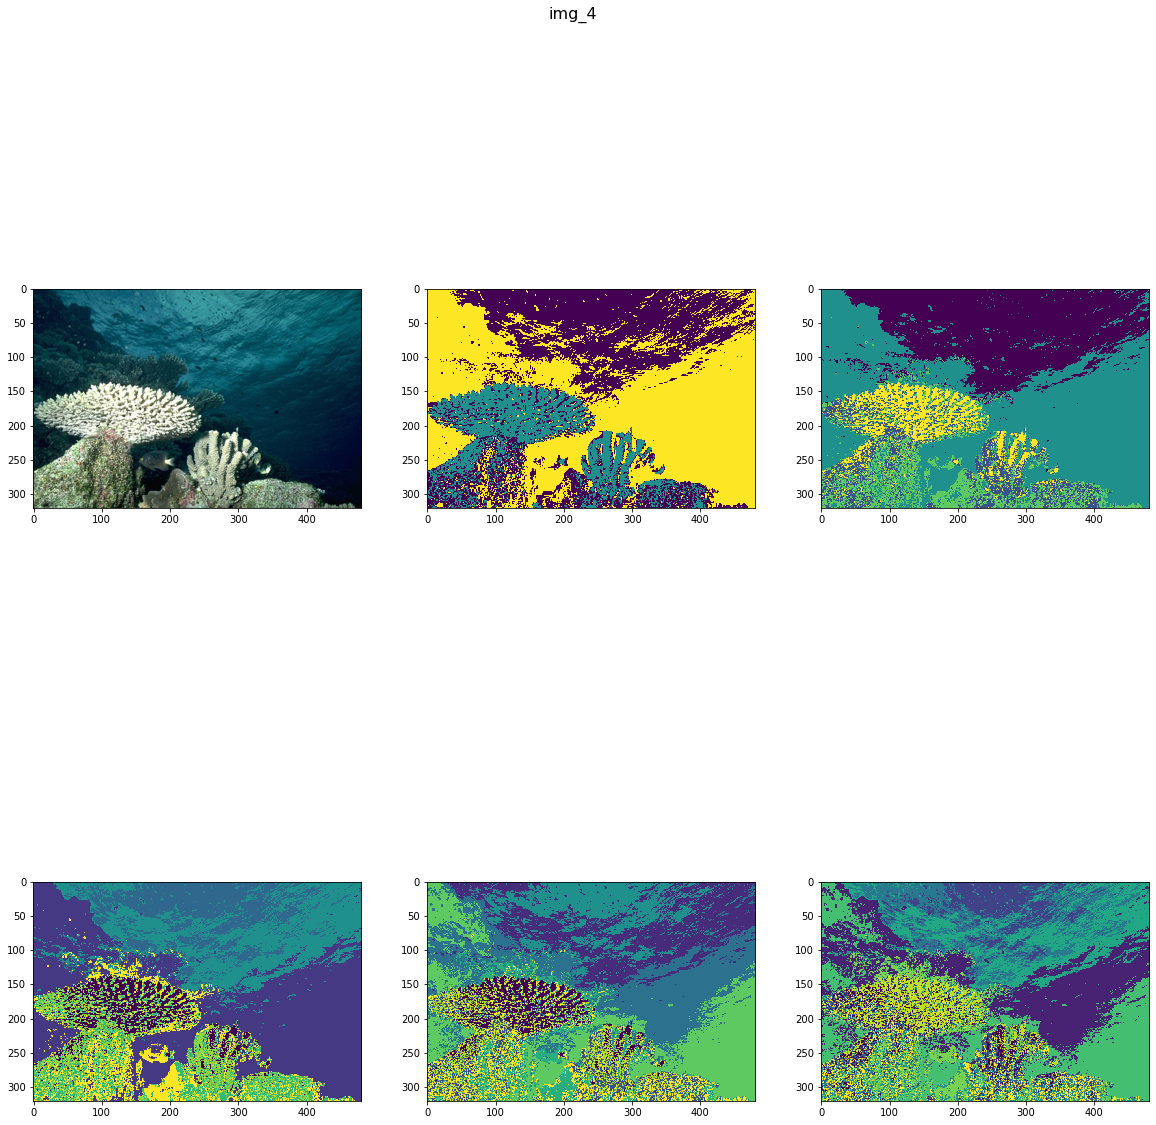

In [64]:
for j in range(5):
    fig, axarr = plt.subplots(2,3, figsize = (20, 20))
    file_name = 'img_' + str(j)
    for i in range(6):
        row = i // 3
        col = i % 3
        if i == 0:
            axarr[row][col].imshow(testing_data[j])
        else:
            axarr[row][col].imshow(pred_img[j][i-1], interpolation='nearest')
        fig.suptitle(file_name, fontsize=16)
    plt.show()
    


# 5. Extra